In [1]:
from deep_traffic_generation.tcvae_pairs import TCVAE_Pairs
from deep_traffic_generation.VAE_Generation import PairsVAE
from traffic.algorithms.generation import Generation
from deep_traffic_generation.core.datasets import TrafficDataset, TrafficDatasetPairs
from traffic.core import Traffic

from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import numpy as np
from os import walk

In [2]:
dataset = TrafficDatasetPairs.from_file(
    ("../deep_traffic_generation/data/training_datasets/landings_south_LFPO_06.pkl", "../deep_traffic_generation/data/training_datasets/takeoffs_south_LFPO_07.pkl"),
    features=["track", "groundspeed", "altitude", "timedelta"],
    scaler=MinMaxScaler(feature_range=(-1,1)),
    # scaler=None,
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)

In [3]:
path = "../deep_traffic_generation/lightning_logs/tcvae_pairs/version_0/"

t = PairsVAE(X = dataset, sim_type = "generation")
t.load(path, dataset.parameters)
g = Generation(generation=t, features = t.VAE.hparams.features, scaler=dataset.scaler) 

In [37]:
#Test for taking max element-wise
import torch.nn as nn

x1 = torch.randn(1000, 64)
x2 = torch.randn(1000, 64)

x = torch.cat((x1.unsqueeze(2),x2.unsqueeze(2)), dim = 2)
x = nn.MaxPool2d((1, 2), stride=(1,1))(x).squeeze(2)

In [34]:
#or we can simply add instead of cat
y = torch.add(x1,x2)
y.shape

torch.Size([1000, 64])

# Latent Space

In [5]:
h1 = t.VAE.encoder_traj1(dataset.data1)
h2 = t.VAE.encoder_traj2(dataset.data2)
# h = torch.cat((h1, h2, torch.unsqueeze(dataset.delta_t, 1)), dim = 1)
h = torch.cat((h1, h2), dim = 1)
# h = torch.cat((h1.unsqueeze(2),h2.unsqueeze(2)), dim = 2)
# h = nn.MaxPool2d((1, 2), stride=(1,1))(h).squeeze(2)

# h = t.VAE.encoder_delta_t(h)
q = t.VAE.lsr(h)

In [6]:
print(t.VAE.scale_traj1, t.VAE.scale_traj2)

Parameter containing:
tensor([0.1119], requires_grad=True) Parameter containing:
tensor([0.0731], requires_grad=True)


In [9]:
t.VAE.lsr.prior_means

tensor([[ 2.0042e-04, -1.7459e-01, -6.1764e-02,  ...,  2.5823e-01,
          5.4827e-01,  4.3923e-01],
        [-8.2950e-02,  6.6240e-01, -1.1080e-01,  ...,  2.3601e-01,
          6.4679e-01, -3.3111e-01],
        [ 6.4504e-01, -1.0144e+00,  1.4959e-01,  ...,  4.6597e-01,
          1.1676e+00, -5.4987e-01],
        ...,
        [-1.7427e-01,  7.0755e-01, -2.3224e-01,  ...,  1.5825e-01,
          8.9141e-01, -2.7145e-01],
        [ 5.6603e-01, -1.7878e-01,  2.4997e-01,  ...,  7.6990e-01,
          4.3712e-01,  1.0648e-01],
        [ 5.8890e-01,  1.6193e-01, -5.3260e-01,  ...,  5.0300e-02,
          1.7235e+00, -4.5800e-01]], grad_fn=<AddmmBackward0>)

In [6]:
t.VAE.lsr.prior_log_vars

tensor([[-2.1276, -1.2103, -1.6800,  ..., -0.6255, -0.5950, -1.0523],
        [-1.5745, -0.8833, -0.9628,  ..., -0.1517, -0.1380, -0.4773],
        [-2.5167, -1.5429, -1.8770,  ..., -0.8919, -0.9419, -1.2616],
        ...,
        [-2.3040, -1.1099, -1.4676,  ..., -0.7250, -0.7853, -1.0913],
        [-2.0236, -1.2018, -1.3715,  ..., -0.6125, -0.5620, -1.0301],
        [-2.3583, -1.2458, -1.7711,  ..., -0.9787, -0.8944, -1.3894]],
       grad_fn=<HardtanhBackward0>)

In [7]:
t.VAE.lsr.dist_params(q)

[tensor([[ 0.3077, -0.4228,  0.7860,  ..., -0.2003,  0.8793,  0.3538],
         [ 0.2056, -0.3469,  0.8334,  ..., -0.1349,  0.9009,  0.3117],
         [ 0.2421, -0.3549,  0.8199,  ..., -0.1643,  0.9283,  0.3483],
         ...,
         [ 0.4357, -0.6214,  0.4254,  ..., -0.3042,  0.0133,  0.6974],
         [ 0.4252, -0.6217,  0.4154,  ..., -0.3015,  0.0169,  0.6825],
         [ 0.4345, -0.6198,  0.4122,  ..., -0.3156,  0.0023,  0.7287]],
        grad_fn=<AddmmBackward0>),
 tensor([[0.4089, 0.4509, 0.4991,  ..., 0.2818, 0.6527, 0.4552],
         [0.3673, 0.4302, 0.4322,  ..., 0.2662, 0.5797, 0.4003],
         [0.3601, 0.4248, 0.4402,  ..., 0.2563, 0.5813, 0.3911],
         ...,
         [0.3444, 0.4352, 0.4153,  ..., 0.4172, 0.4637, 0.4738],
         [0.3539, 0.4415, 0.4152,  ..., 0.4144, 0.4652, 0.4756],
         [0.3616, 0.4653, 0.4425,  ..., 0.4373, 0.4860, 0.5002]],
        grad_fn=<ExpBackward0>)]

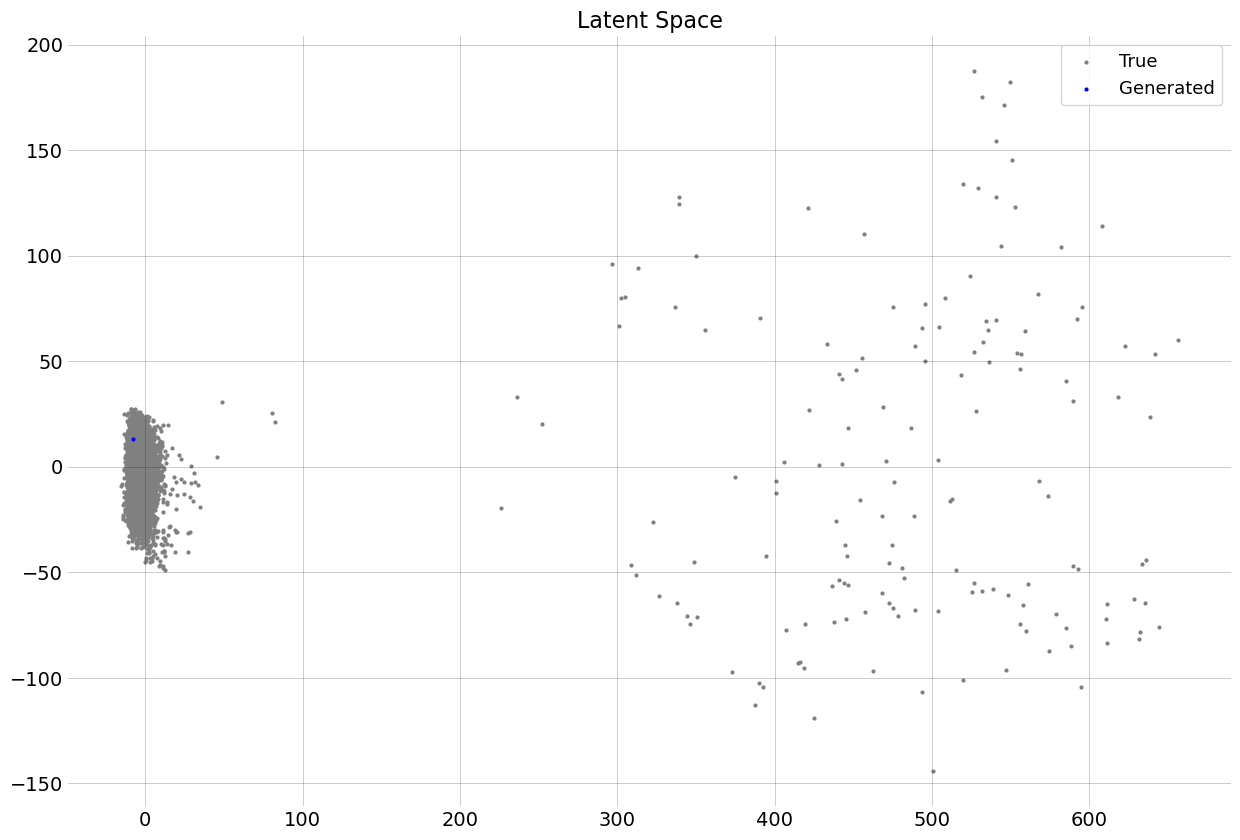

In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

n_gen = 1
Z = t.latent_space(n_gen)

#Only fitted on train data
pca = PCA(n_components=2).fit(Z[:-n_gen])
Z_embedded = pca.transform(Z)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, figsize=(15, 10))

    ax.scatter(Z_embedded[:-n_gen, 0], Z_embedded[:-n_gen, 1], s=4, c ='grey', label = "True")
    ax.scatter(Z_embedded[-n_gen:, 0], Z_embedded[-n_gen:, 1], s=4, c='blue', label = "Generated")
    ax.title.set_text("Latent Space")
    ax.legend()

    plt.show()

In [16]:
p = pca.inverse_transform(Z_embedded[Z_embedded[:,0] > 200])
t.decode(torch.Tensor(p))[0]

array([[  325.908   ,   356.39423 , 12797.148   , ...,   873.0858  ,
         1041.2499  ,    76.12998 ],
       [  325.5827  ,   353.32315 , 12805.783   , ...,   872.31287 ,
         1041.8959  ,    77.032875],
       [  324.9028  ,   357.33508 , 12690.234   , ...,   871.8885  ,
         1041.4695  ,    74.62958 ],
       ...,
       [  325.26495 ,   353.533   , 12788.921   , ...,   874.1059  ,
         1042.1144  ,    76.870125],
       [  325.5782  ,   352.62384 , 12823.481   , ...,   871.4426  ,
         1041.5815  ,    77.70898 ],
       [  321.9684  ,   342.73596 , 12577.905   , ...,   832.55164 ,
         1032.1062  ,    75.205   ]], dtype=float32)

# Reconstruction

In [7]:
from traffic.core.projection import EuroPP
from traffic.data import airports
from traffic.drawing import countries
import matplotlib.pyplot as plt

j = np.random.randint(len(dataset))

original1 = dataset.data1[j].unsqueeze(0)
original2 = dataset.data2[j].unsqueeze(0)
original1 = original1.transpose(1,2).reshape((original1.shape[0], -1))
original2 = original2.transpose(1,2).reshape((original2.shape[0], -1))
# original = torch.cat((dataset.delta_t[j].view(1,1), original1, original2), dim = 1)
original = torch.cat((original1, original2), dim = 1)
original = dataset.scaler.inverse_transform(original)
# original_traf_ld = g.build_traffic(original[:,1:801], coordinates = dict(latitude = 48.704496, longitude = 2.273339), forward=False)
# original_traf_to = g.build_traffic(original[:,801:], coordinates = dict(latitude = 48.736157, longitude = 2.45031), forward=True)
original_traf_ld = g.build_traffic(original[:,:800], coordinates = dict(latitude = 48.704496, longitude = 2.273339), forward=False)
original_traf_to = g.build_traffic(original[:,800:], coordinates = dict(latitude = 48.736157, longitude = 2.45031), forward=True)

h1 = t.VAE.encoder_traj1(dataset.data1[j].unsqueeze(0))
h2 = t.VAE.encoder_traj2(dataset.data2[j].unsqueeze(0))
# h = torch.cat((h1, h2, dataset.delta_t[j].view(1,1)), dim = 1)
h = torch.cat((h1, h2), dim = 1)
# h = t.VAE.encoder_delta_t(h)
z = t.VAE.lsr(h).rsample()
# dt, t1, t2 = t.decode(z)
t1, t2 = t.decode(z)
reconstructed_traf_ld = g.build_traffic(t1, coordinates = dict(latitude = 48.704496, longitude = 2.273339), forward=False)
reconstructed_traf_to = g.build_traffic(t2, coordinates = dict(latitude = 48.736157, longitude = 2.45031), forward=True)


with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, subplot_kw=dict(projection=EuroPP()))
    original_traf_ld.plot(ax, c="#4c78a8", lw = 3, label = "Original")
    original_traf_to.plot(ax, c="#4c78a8", lw = 3)
    reconstructed_traf_ld.plot(ax, c="orange", label = "Reconstructed")
    reconstructed_traf_to.plot(ax, c="orange")
    plt.legend()

    airports["LFPO"].point.plot(ax, shift=dict(units="dots", x=20, y=40), text_kw= {"fontsize" : 18})

    plt.show()

ValueError: operands could not be broadcast together with shapes (1,1600) (1601,) (1,1600) 